# Tutorial for Geoseg 
> __version__ ==   alpha

>  __author__ ==  Go-Hiroaki

# Overview:

## 1. Evaluating with pretrained models
> Test model performance by providing pretrained models

## 2. Re-training with provided dataset
> Trained new models with provide training datastet



> Train and test models with your own dataset



In [5]:
# Download repo.
# git clone  https://github.com/huster-wgm/geoseg.git
# cd geoseg
ls

BR-Net.py    FCNs.py       logs/         result/       utils/
cGAN.py      FPN.py        MC-FCN.py     ResUNet.py    visSingleComparison.py
checkpoint/  How-to.ipynb  models/       run-model.sh  visSingle.py
config.py    __init__.py   __pycache__/  SegNet.py
dataset/     LICENSE       README.md     UNet.py


## 1. Evaluating with pretrained models

### 1.1 Prepared evalution dataset
    prepare your dataset refer to utlis/dataset.py


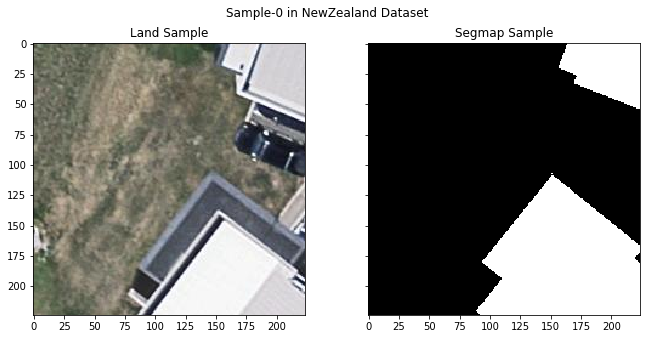

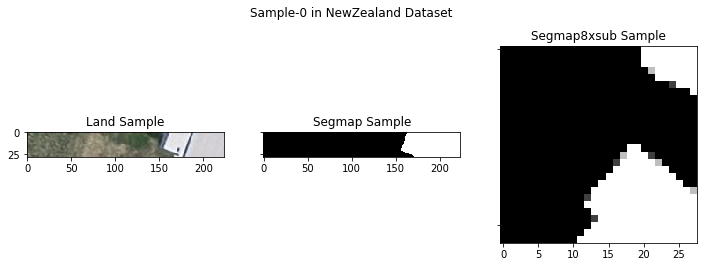

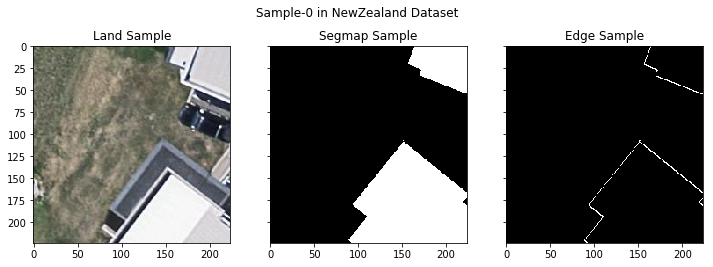

In [9]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
"""
  @CreateTime:   2018-01-26T16:50:00+09:00
  @Email:  guangmingwu2010@gmail.com
  @Copyright: go-hiroaki
  @License: MIT
"""
import sys

Utils_DIR = os.path.join("./utils")
sys.path.append(Utils_DIR)

import numpy as np
import pandas as pd
from torch.utils import data
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import vision
import argparse




class NewZealand(data.Dataset):
    """ 'NewZealand' dataset object
    args:
        partition: (str) partition of the data ['nz-train-slc', 'nz-test-slc']
        split: (str) split of the data ['train', 'val', 'all']
    """

    def __init__(self, partition='nz-train-slc', split='train'):
        self.dataset = os.path.join(
            Utils_DIR, '../dataset', partition)

        self._landpath = os.path.join(self.dataset, 'land', '%s')
        self._segpath = os.path.join(self.dataset, 'segmap', '%s')

        # get image ids
        infos = pd.read_csv(os.path.join(
            self.dataset, '{}-infos.csv'.format(split)))
        self.ids = infos['id'].tolist()

        # get label class
        self.nb_class = 1
        # get img sizes
        img_sam = imread(self._landpath % self.ids[0])
        self.img_rows, self.img_cols = img_sam.shape[:2]

    def __len__(self):
        return len(self.ids)


class nzLS(NewZealand):
    """
        return 'Land-Segmap' of NewZealand Dataset
        required data format for normal models \
    """

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_land = imread(self._landpath % img_id)
        img_land = (img_land / 255).astype('float32')

        img_seg = imread(self._segpath % img_id)
        img_seg = (np.expand_dims(img_seg, -1) / 255).astype('float32')

        img_land = img_land.transpose((2, 0, 1))
        img_seg = img_seg.transpose((2, 0, 1))
        return img_land, img_seg

    def show(self, idx):
        img_land = imread(self._landpath % self.ids[idx])
        img_seg = imread(self._segpath % self.ids[idx])

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11, 5))
        f.suptitle('Sample-{} in NewZealand Dataset'.format(idx))
        ax1.imshow(img_land)
        ax1.set_title('Land Sample')
        ax2.imshow(img_seg, "gray")
        ax2.set_title('Segmap Sample')
        plt.show()

class nzLS8xsub(NewZealand):
    """
        return 'Land-Segmap-Segmap8xsub' of NewZealand Dataset
        required data format for MC-FCN \
        "Automatic Building Segmentation of Aerial Imagery Using Multi-Constraint Fully Convolutional Networks. \
        Remote Sens. 2018"
    """

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_land = imread(self._landpath % img_id)
        img_rows, img_cols = img_land.shape[:2]
        img_land = (img_land / 255).astype('float32')

        img_seg = imread(self._segpath % img_id)
        img_seg_sub = resize(
            img_seg, (img_rows // 8, img_cols // 8), mode='edge')
        # denoise after resing image
        img_seg_sub[img_seg_sub < 0.5] = 0.0
        img_seg_sub[img_seg_sub >= 0.5] = 1.0
        img_seg_sub = (np.expand_dims(img_seg_sub, -1)).astype('float32')

        img_seg = (np.expand_dims(img_seg, -1) / 255).astype('float32')

        img_land = img_land.transpose((2, 0, 1))
        img_seg = img_seg.transpose((2, 0, 1))
        img_seg_sub = img_seg_sub.transpose((2, 0, 1))
        return img_land, img_seg, img_seg_sub

    def show(self, idx):
        img_land = imread(self._landpath % self.ids[idx])
        img_seg = imread(self._segpath % self.ids[idx])
        img_rows, img_cols = img_land.shape[:2]
        img_seg_sub = resize(
            img_seg, (img_rows // 8, img_cols // 8), mode='edge')
        img_seg_sub = (img_seg_sub * 255).astype('uint8')
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
        f.suptitle('Sample-{} in NewZealand Dataset'.format(idx))
        ax1.imshow(img_land)
        ax1.set_title('Land Sample')
        ax2.imshow(img_seg, 'gray')
        ax2.set_title('Segmap Sample')
        ax3.imshow(img_seg_sub, 'gray')
        ax3.set_title('Segmap8xsub Sample')
        plt.show()


class nzLSE(NewZealand):
    """
        return 'Land-Segmap-Edge' of NewZealand Dataset
        required data format for BR-Net \
        "A Boundary Regulated Network for Accurate Roof Segmentation and Outline Extraction \
        Remote Sens. 2018."
    """

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_land = imread(self._landpath % img_id)
        img_land = (img_land / 255).astype('float32')

        img_seg = imread(self._segpath % img_id)
        img_edge = vision.shift_edge(img_seg)

        # img_seg = rgb2gray(img_seg)
        # img_edge = np.expand_dims(vision.canny_edge(img_seg), dim=-1)
        # img_edge = (img_edge / 255).astype("float32")

        img_seg = (np.expand_dims(img_seg, -1) / 255).astype('float32')
        img_edge = (np.expand_dims(img_edge, -1) / 255).astype('float32')

        img_land = img_land.transpose((2, 0, 1))
        img_seg = img_seg.transpose((2, 0, 1))
        img_edge = img_edge.transpose((2, 0, 1))

        return img_land, img_seg, img_edge

    def show(self, idx):
        img_land = imread(self._landpath % self.ids[idx])
        img_seg = imread(self._segpath % self.ids[idx])
        img_edge = vision.shift_edge(img_seg)

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
        f.suptitle('Sample-{} in NewZealand Dataset'.format(idx))
        ax1.imshow(img_land)
        ax1.set_title('Land Sample')
        ax2.imshow(img_seg, 'gray')
        ax2.set_title('Segmap Sample')
        ax3.imshow(img_edge, 'gray')
        ax3.set_title('Edge Sample')
        plt.show()

if __name__ == "__main__":
    partition = 'nz-train-slc'
    split = "all" # ["train","val","test","all"]
    # NewZealand dataset
    lsdata = nzLS(partition, split)
    land, seg = lsdata[0]
    lsdata.show(0)

    ls8xdata = nzLS8xsub(partition, split)
    land, seg, seg8x = ls8xdata[0]
    ls8xdata.show(0)

    lsedata = nzLSE(partition, split)
    land, seg, edge = lsedata[0]
    lsedata.show(0)

### 1.2 Download pretrained models

> 1. FCN8s_iter_5000.pth [LINK](https://drive.google.com/open?id=1KHs7coyXAipz8t5cN_lbTC4MOYi8FddI)
> 2. FCN16s_iter_5000.pth [LINK](https://drive.google.com/open?id=1wlORkMx_ykmHysShUKY4UcCYs-fVaen6)
> 3. FCN32s_iter_5000.pth [LINK](https://drive.google.com/open?id=1OR_Sk66RAGtKrp0quvqazRkL0xtAH8RY)
> 4. SegNet_iter_5000.pth [LINK](https://drive.google.com/open?id=1J0aRjFG-zOSSXnynm02VaYxjw1tjx-qC)
> 5. UNet_iter_5000.pth [LINK](https://drive.google.com/open?id=17X0aCgRx3XXgH1fcfLoLwgcbWIzxZe5K)
> 6. FPN_iter_5000.pth [LINK](https://drive.google.com/open?id=1fWrCnGQJBZTw7m5OZlQvH5-R_JJlBA-r)
> 7. ResUNet_iter_5000.pth [LINK](https://drive.google.com/open?id=1jGs_PxEMXCshOzXdg9LuFJxe8kO39oxT)
> 8. MC-FCN_iter_5000.pth [LINK](https://drive.google.com/open?id=1Kt_JmR0ZGXvK9kuTmDOek5l1SsHX4xhz)
> 9. BR-Net_iter_5000.pth [LINK](https://drive.google.com/open?id=1rytD9tzAq2mne5yf3XEh-jTSHlvQvedT)
> * Upcoming ...

    After downloading corresponding pretrained models, save them at checkpoints/ .


In [5]:
ls ../checkpoint/

BR-Net_iter_5000.pth  FCN8s_iter_5000.pth   ResUNet_iter_5000.pth
FCN16s_iter_5000.pth  FPN_iter_5000.pth     SegNet_iter_5000.pth
FCN32s_iter_5000.pth  MC-FCN_iter_5000.pth  UNet_iter_5000.pth


### 1.3 Run evaluation scripts

* sinle model

```
visSingle.py -h
   optional arguments:
  -h, --help            show this help message and exit
  -checkpoints CHECKPOINTS [CHECKPOINTS ...]
                        checkpoints used for making prediction
  -spaces SPACES [SPACES ...]
                        barrier space for merging
  -direction {horizontal,vertical}
                        merge image direction
  -disp_cols DISP_COLS  cols for displaying image
  -edge_fn {shift,canny}
                        method used for edge extraction
  -gen_nb GEN_NB        number of generated image
  -color COLOR          background color for generated rgb result
  -partition PARTITION  partition of dataset for loading
  -disk DISK            dilation level
  -cuda CUDA            using cuda for optimization
```
  
  The generate result will show up at result/single
   - BR-Net ![time](./result/single/BR-Net_canny_segmap_edge_0.png)
   
* multi models
```
visSingleComparison.py -h
    optional arguments:
    -h, --help            show this help message and exit
    -checkpoints CHECKPOINTS [CHECKPOINTS ...]
                        checkpoints used for making prediction
    -spaces SPACES [SPACES ...]
                        barrier spaces for merging
    -direction {horizontal,vertical}
                        merge image direction
    -disp_cols DISP_COLS  cols for displaying image
    -target {segmap,edge}
                        target for model prediction [segmap, edge]
    -edge_fn {shift,canny}
                        method used for edge extraction
    -gen_nb GEN_NB        number of generated image
    -eval_fn {ov,precision,recall,f1_score,jaccard,kappa}
                        method used for evaluate performance
    -significance SIGNIFICANCE
                        significant different level between methods
    -color COLOR          background color for generated rgb result
    -partition PARTITION  partition of dataset for loading
    -disk DISK            dilation level
    -batch_size BATCH_SIZE
                        batch size for model prediction
    -cuda CUDA            using cuda for optimization
```
  The generate result will show up at result/single-comparison
   - Segmap FCN32s_FCN16s_FCN8s ![time](./result/single-comparison/segmap_FCN32s_FCN16s_FCN8s_1.png)
   - Edge FCN32s_FCN16s_FCN8s ![time](./result/single-comparison/edge_FCN32s_FCN16s_FCN8s_1.png)

## 2. Re-train with provided dataset

### 2.1 Download training dataset
> Training dataset [LINK](https://drive.google.com/file/d/1boGcJz9TyK9XB4GUhjCHVu8XGtbgjjbi/view?usp=sharing).
Unzip and place to datasets/

### 2.2 Run training scripts
> FCN.py, UNet.py, etc.

## 3. Training with personal dataset
### 3.1 Prepare your own dataset
### 3.2 Run training scripts

In [ ]:
Step